Σμαράγδη Μπενέτου 03118048 

Σοφία Μπαρκάτσα 03118204

Μαργαρίτα Ελένη Τσαρμποπούλου 03118848

## Setup

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.


In [ ]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This tutorial uses lots of imports, mostly for loading the dataset(s).

In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request
import seaborn as sns

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

### Choose and Download dataset


In [ ]:
# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

4376381805/4376381805 [==============================] - 373s 0us/step


In [ ]:
# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

In [ ]:
path="."

IMAGE_DIR="image_dir"
path = pathlib.Path(path)
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
cap_dict = collections.defaultdict(list)

for fname, cap in captions:
  cap_dict[fname].append(cap)


train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]

test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]

train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

# Αρχική επίδοση με κωδικα tutorial

In [ ]:
#input

IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
#example
t = tokenizer([['a cat in a hat'], ['a robot dog']])
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
t

<tf.RaggedTensor [[3, 2, 755, 5, 2, 63, 4], [3, 2, 2866, 34, 4]]>

In [ ]:

def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )
  
train_ds = prepare_dataset(train_raw, tokenizer)
test_ds = prepare_dataset(test_raw, tokenizer)

class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

#decoder

class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

#output
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias

output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

#model

class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer
  
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

   def simple_gen(self, image, temperature=1, beam_size=2):
    initial = self.word_to_index([['[START]']])                        # 'START' token == 3
    img_features = self.feature_extractor(image[tf.newaxis, ...])      # extract features from image
    # original code from tutorial
    if temperature >=0:
      tokens = initial # (batch, sequence)
      for n in range(50):
          preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
          preds = preds[:,-1, :]  #(batch, vocab)
          print(preds, "\n")
          if temperature==0:
              next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
          else:
              next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
          tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

          if next[0] == self.word_to_index('[END]'):
            break
      words = index_to_word(tokens[0, 1:-1])
      result = tf.strings.reduce_join(words, axis=-1, separator=' ')
      return result.numpy().decode()
    
    # if temperature <0 then we use beam search, 
    # with as many beams are defined (default=2)
    #following code by 
    # https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24#:~:text=Beam%20Search%20%E2%80%94%20What%20it%20does
    else:  
      tokens_list = [(initial, 0.0)]                  
      final_tokens_list = []                          

      remaining_beam_size = beam_size                 # Counter for how many branches in the beam search tree have not terminated yet
      for n in range(50):
        if remaining_beam_size == 0:
          break
        new_tokens_list = []                          
        for tokens, prob in tokens_list:              
          if tokens[0][-1] == self.word_to_index('[END]'):
            remaining_beam_size -= 1
            final_tokens_list.append((tokens, prob))
            continue
          preds = self((img_features, tokens)).numpy()    
          preds = preds[:, -1, :]                         
          top_b_preds = tf.math.top_k(preds, k=remaining_beam_size) # b words with the biggest probability 
          top_b_tokens = top_b_preds.indices              # tokens 
          top_b_prob = top_b_preds.values                 # probabilities
          for i in range(remaining_beam_size):
            next_token = [[top_b_tokens[0][i]]]           # next token to be added to the sentence (in one branch)
            new_tokens = tf.concat([tokens, next_token], axis=1)
            new_log_prob = prob + top_b_prob[0][i]
            new_tokens_list.append((new_tokens, new_log_prob))
          
        tokens_list = sorted(new_tokens_list, key=lambda x: -x[1])[:remaining_beam_size] # Sort the list with b*b sentences and keep the first b

      # Return the sentence with the biggest (probability / sentence length) score
      tokens, prob = max(final_tokens_list, key=lambda x: x[1]/len(x[0][0, 1:-1]))
      words = index_to_word(tokens[0, 1:-1])
      result = tf.strings.reduce_join(words, axis=-1, separator=' ')
      
      return result.numpy().decode()

model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [ ]:
#train and loss

def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=40,
    callbacks=callbacks)


In [ ]:
#plotting metrics
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()


NameError: ignored

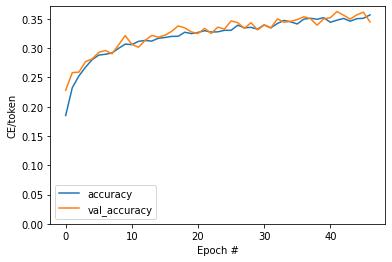

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

# Αξιολόγηση της ποιότητας του captioning (BLEU)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# references λίστα από reference captions για την εικόνα
# hypothesis generated caption για την εικόνα
def single_image_bleu(references , hypothesis):
    # αφαίρεση από τα references την τελική τελεία
    references = [caption[:-1] for caption in references]
    # BLEU score
    weights = (0.4, 0.3, 0.2, 0.1)
    smoothing = SmoothingFunction().method1
    return sentence_bleu(references, hypothesis, weights=weights, smoothing_function=smoothing)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# references λίστα από reference captions για την εικόνα
# hypothesis λίστα από generated captions για την εικόνα
def more_images_bleu(references , hypothesis):
    # αφαίρεση από τα references την τελική τελεία
    references = [[caption[:-1]] for caption in references]
    # BLEU score
    weights = (0.4, 0.3, 0.2, 0.1)
    smoothing = SmoothingFunction().method1
    return corpus_bleu(references, hypothesis, weights=weights, smoothing_function=smoothing)

Κάνει πολύ ώρα για να αξιολογείσει το captioning όλου του test set, για αυτό αξιολογούμε ένα μέρος του.

In [ ]:
test_hypothesis = []
test_references = []
for image_path, true_captions in test_captions[:500]:
    image = load_image(image_path)
    hypothesis = model.simple_gen(image)
    test_hypothesis.append(hypothesis)
    test_references.append(true_captions)

test_corpus_bleu = more_images_bleu(test_hypothesis, test_references)
print("Test set corpus BLEU score:", test_corpus_bleu)

Test set corpus BLEU score: 0


In [ ]:
idx = 37 
hypothesis = test_hypothesis[idx]
references = test_references[idx]
single_example_bleu = single_image_bleu(hypothesis, references)
print("BLEU score for example", idx, ":", single_example_bleu)

BLEU score for example 37 : 0


In [ ]:
test_captions[idx][0]

'/content/image_dir/_61222200.jpg'

references ['These people are attending a conference where there are all red chairs and tables .', 'group of people seated at red chair and tables .', 'A group of people are attending a conference .', 'People listen intently in a conference room .', 'People at a meeting , listening intently .']
hypothesis a crowd of people gathered around a couch to short women in the people one in a crowd asleep in the background


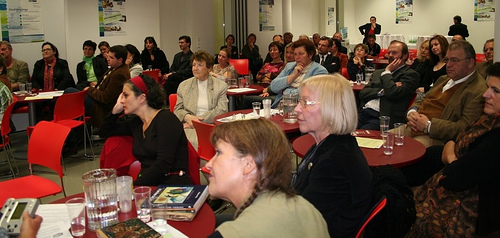

In [ ]:
print('references',test_references[idx])
print('hypothesis',test_hypothesis[idx])
Image.open('/content/image_dir/_61222200.jpg')


# Προεπεξεργασία κειμένου

1. Μελετήστε τα captions. Θα μπορούσε η συνάρτηση standardize να περιλαμβάνει και άλλα φίλτρα κανονικοποίησης; Προσοχή, εδώ δεν κάνουμε stemming.
2. Πολύ μικρά ή πολύ μεγάλα σε μήκος captions μπορεί να επηρεάζουν αρνητικά την εκπαίδευση και την απόδοση του μοντέλου. Εξετάστε αν μπορείτε να χρησιμοποιήσετε ένα "καλό" παράθυρο μήκους για τα captions. Hint: δοκιμάστε ένα ιστόγραμμα.
3. To tutorial αποφασίζει ad hoc για ένα vocabulary 5000 λέξεων. Δοκιμάστε και κάποια διαφορετικά (μικρότερα ή μεγαλύτερα) μεγέθη vocabulary.

In [ ]:
os.listdir('/content')


Διατηρήσαμε μήκη από captions μεταξύ 5 και 30 λέξεων, ώστε να έχουμε ένα range από 25 διαφορετικά μήκη, χωρίς πολύ μικρά ή πολύ μεγάλα captions.

In [ ]:
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
min_len=5
max_len=30

words_before=[]
words_after=[]

cap_dict = collections.defaultdict(list)
for fname, cap in captions:
    num_words = len(cap.split())
    words_before.append(num_words)
    if (num_words > min_len and num_words < max_len):
        cap_dict[fname].append(cap)
        words_after.append(num_words)

num_captions = 0
for caps in cap_dict.values():
    num_captions += len(caps)
print("Number of captions:", num_captions)

In [ ]:
print("Mean number of words in a caption before removing: ", np.mean(words_before))
sns.set(style="darkgrid")
sns
sns.histplot(data=words_before)
plt.show()

In [ ]:
print("Mean number of words in a caption after removing: ", np.mean(words_after))
sns.set(style="darkgrid")
sns
sns.histplot(data=words_after)
plt.show()

In [ ]:
print(cap_dict['_73328886.jpg'])
print(cap_dict['_648183060.jpg'])

Βλέπουμε ότι έχουμε μέγεθος vocabulary 22.133 και το κάνουμε 10.000.

In [ ]:
vocab = set([word for captions in cap_dict.values() for caption in captions for word in caption.split()])
len(vocab)        

In [ ]:
from collections import Counter
word_freq = Counter(word for captions in cap_dict.values() for caption in captions for word in caption.split())
vocab = set([word for word, freq in word_freq.most_common(10000)])

for fname, caps in cap_dict.items():
    for cap in caps:
        words = cap.split()
        if not all(word in vocab for word in words):
            cap_dict[fname].remove(cap)

num_captions = 0
for caps in cap_dict.values():
    num_captions += len(caps)
print("Number of captions:", num_captions)

Περιμένουμε 5 captions ανα image οπότε ελέγχουμε όσες εικόνες έχουν παραπάνω και αφαιρούμε τα 'οχι σχετικά caption

In [ ]:
for l in cap_dict.values():

  if (len(l)>5):
    image = list(cap_dict.keys())[list(cap_dict.values()).index(l)]
    print(f"{image} has more than 5 captions.")

In [ ]:
Image.open('/content/image_dir/_287255355.jpg')

In [ ]:
cap_dict['_287255355.jpg']

In [ ]:
cap_dict['_287255355.jpg'] = cap_dict['_287255355.jpg'][5:] 
cap_dict['_287255355.jpg']

In [ ]:
images = os.listdir('/content/image_dir')
print(len(images))

In [ ]:
train_files = (path/train_files_list).read_text().splitlines()
train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
   
test_files = (path/test_files_list).read_text().splitlines()
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]
   
train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

In [ ]:
train_images = pd.read_csv((path/train_files_list), header=None)
train_caps = pd.DataFrame(train_captions)
train = pd.concat([train_images.iloc[:, 0], train_caps.iloc[:, 1]], axis=1)
train.head()

In [ ]:
test_images = pd.read_csv((path/train_files_list), sep='|', header=None)
test_caps = pd.DataFrame(test_captions)
test = pd.concat([test_images.iloc[:, 0], test_caps.iloc[:, 1]], axis=1)
test.head()

# Encoder

In [ ]:
mobilenet2 = tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=IMAGE_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
mobilenet2.trainable=False

model2 = Captioner(tokenizer, feature_extractor=mobilenet2, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

71686520/71686520 [==============================] - 4s 0us/step


In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

history = model2.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=40,
    callbacks=callbacks)


Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 4.8813 - masked_acc: 0.1962

a man in a blue shirt is is in a red
three people in a blue field in a toy
two boy in the a green ball to the camera underwater

100/100 [==============================] - 98s 490ms/step - loss: 4.8813 - masked_acc: 0.1962 - val_loss: 4.4439 - val_masked_acc: 0.2401
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 4.3798 - masked_acc: 0.2506

a man in a blue shirt is in the water
the people in a blue jacket
a male in a skateboard same along the middle he of hand

100/100 [==============================] - 31s 308ms/step - loss: 4.3798 - masked_acc: 0.2506 - val_loss: 4.1293 - val_masked_acc: 0.2681
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 4.1706 - masked_acc: 0.2733

a man in a blue shirt is jumping in a red and a white ball
a man with a ball in a water
him in white running a pink ball in a field

100/100 [==============================] -

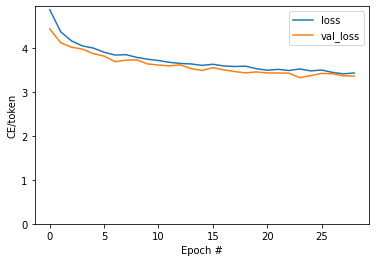

In [ ]:
#plotting metrics
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

Το accuracy δεν βελτιώνεται παρόλα αυτά επιτυγχάνεται η σύγκλιση γρηγορότερα

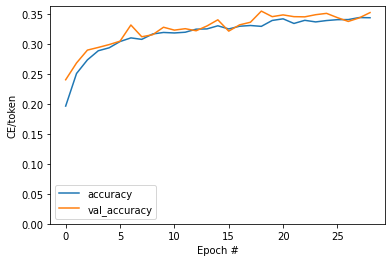

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

# Embeddings

In [ ]:
import gensim.downloader

In [ ]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')


[=================================================-] 98.3% 64.8/66.0MB downloaded

In [ ]:
#example
glove_vectors.wv['twitter']

<ipython-input-48-69aae2bccb9c>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  glove_vectors.wv['twitter']


array([ 0.55473  ,  0.14251  ,  1.577    ,  0.44222  , -0.40965  ,
       -0.24373  , -1.2366   , -0.64589  ,  0.31804  ,  0.48623  ,
       -0.20947  ,  0.019861 , -0.28046  , -0.64705  ,  0.87607  ,
       -0.28965  , -1.1877   , -0.22703  ,  0.73132  ,  0.064986 ,
        0.34437  , -0.044798 ,  0.85787  ,  1.0463   ,  1.3781   ,
       -0.21831  ,  0.45545  , -0.36639  , -0.32279  , -0.34018  ,
        1.5663   , -0.028824 ,  0.0062708, -0.62084  , -1.3351   ,
        0.082663 , -0.085856 , -0.67657  , -1.1872   , -0.40016  ,
        1.1583   , -0.50842  , -1.8528   ,  0.49679  ,  0.94368  ,
       -0.97676  ,  0.30505  ,  0.15514  ,  0.26331  , -0.10485  ],
      dtype=float32)

In [ ]:

class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

class EmbeddingPretrained(tf.keras.layers.Layer):
  def __init__(self, model, depth, max_length, vocab_size):
    super().__init__()
    self.wordvectors = model.wv
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=depth, weights=[model.wv], trainable=False)
    self.add = tf.keras.layers.Add()
    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        weights=[model.wv], 
        trainable=False,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)
    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)
    return self.add([seq,x])
    
class Captioner2(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 
    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)
    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer
  
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

  def simple_gen(self, image, temperature=1):
    initial = self.word_to_index([['[START]']]) # (batch, sequence)
    img_features = self.feature_extractor(image[tf.newaxis, ...])

    tokens = initial # (batch, sequence)
    for n in range(50):
      preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
      preds = preds[:,-1, :]  #(batch, vocab)
      if temperature==0:
          next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
      else:
          next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
      tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

      if next[0] == self.word_to_index('[END]'):
        break
    words = index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    return result.numpy().decode()


model3 = Captioner2(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

history = model3.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=40,
    callbacks=callbacks)

# Sentence Generator

Για την υλοποίηση του νέου setence generator με την χρήση της μεθόδου Beam Search, τροποποιήσαμε την μέθοδο simple_gen όπως αυτή δινόταν στο tutorial. Η τροποποιημένη μέθοδος, αν δεχθεί σαν όρισμα temperature <0 (για παράδειγμα -1) τότε υλοποιεί την μέθοδο Beam Search, με αριθμο beams όσα οριστούν. Σε αλλη περίπτωση, λειτουργεί κανονικά όπως πορηγουμένως.

# Αξιολόγηση της ποιότητας του captioning (BLEU) του νέου μοντέλου

In [ ]:
test_hypothesis = []
test_references = []
for image_path, true_captions in test_captions[:1000]:
    image = load_image(image_path)
    hypothesis = model3.simple_gen(image,temperature=-1, beam_size=2)
    test_hypothesis.append(hypothesis)
    test_references.append(true_captions)

test_corpus_bleu = more_images_bleu(test_hypothesis, test_references)
print("Test set corpus BLEU score:", test_corpus_bleu)